In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#carregando os datasets que serão utilizados na análise
df_orders = pd.read_csv('Datasets/olist_orders_dataset.csv')
df_order_items = pd.read_csv('Datasets/olist_order_items_dataset.csv')
df_order_reviews = pd.read_csv('Datasets/olist_order_reviews_dataset.csv')

In [20]:
#unindo as tabelas
df_completo = pd.merge(df_orders, df_order_items, on='order_id', how='inner')
df_completo = pd.merge(df_completo, df_order_reviews, on='order_id', how='inner')

In [25]:
#colunas de data para conversão
cols_data = [
    'order_purchase_timestamp', 
    'order_estimated_delivery_date', 
    'order_delivered_customer_date'
]

#convertendo para datetime
for col in cols_data:
    df_completo[col] = pd.to_datetime(df_completo[col])

In [26]:
#realizando os cálculos de métricas logísticas
df_completo['dias_atraso'] = (
    df_completo['order_delivered_customer_date'] - 
    df_completo['order_estimated_delivery_date']
).dt.days

#tempo total de espera do cliente
df_completo['tempo_espera'] = (
    df_completo['order_delivered_customer_date'] - 
    df_completo['order_purchase_timestamp']
).dt.days

#status em binário 
df_completo['is_late'] = df_completo['dias_atraso'].apply(lambda x: 1 if x > 0 else 0)

In [29]:
#diagnóstico de Outliers (dias_atraso)
#variável temporária sem nulos para o cálculo estatístico
delay_clean = df_completo['dias_atraso'].dropna()

Q1 = delay_clean.quantile(0.25)
Q3 = delay_clean.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_sup = delay_clean[delay_clean > limite_superior].count()
outliers_inf = delay_clean[delay_clean < limite_inferior].count()

print("\n--- Diagnóstico de Outliers (Estatístico) ---")
print(f"Valor Mínimo encontrado: {delay_clean.min()} dias")
print(f"Valor Máximo encontrado: {delay_clean.max()} dias")
print(f"Limite Superior Sugerido (IQR): {limite_superior:.2f} dias")
print(f"Quantidade de Outliers Superiores: {outliers_sup}")
print(f"Quantidade de Outliers Inferiores: {outliers_inf}")


--- Diagnóstico de Outliers (Estatístico) ---
Valor Mínimo encontrado: -147 dias
Valor Máximo encontrado: 188 dias
Limite Superior Sugerido (IQR): 8.00 dias
Quantidade de Outliers Superiores: 2697
Quantidade de Outliers Inferiores: 2161


In [30]:
#removendo pedidos sem data de entrega
df_clean = df_completo.dropna(subset=['order_delivered_customer_date']).copy()

#aplicando filtro de negócio (removendo ruídos extremos)
#matendo: entregas até 40 dias antes do prazo e até 90 dias após o prazo
df_clean = df_clean[
    (df_clean['dias_atraso'] >= -40) & 
    (df_clean['dias_atraso'] <= 90)
]

#verificando o novo volume de dados
print(f"Volume original: {len(df_completo)}")
print(f"Volume após limpeza: {len(df_clean)}")
print(f"Porcentagem mantida: {(len(df_clean)/len(df_completo))*100:.2f}%")

Volume original: 110012
Volume após limpeza: 109290
Porcentagem mantida: 99.34%


### Análise comparativa: Entrega no prazo vs entrega atrasada

In [ ]:
#comparação de médias
resumo_status = df_clean.groupby('is_late')['review_score'].mean().reset_index()
resumo_status['is_late'] = resumo_status['is_late'].map({0: 'No Prazo', 1: 'Atrasado'})

print("--- Nota Média por Status de Entrega ---")
print(resumo_status)

--- Nota Média por Status de Entrega ---
    is_late  review_score
0  No Prazo      4.207755
1  Atrasado      2.250425


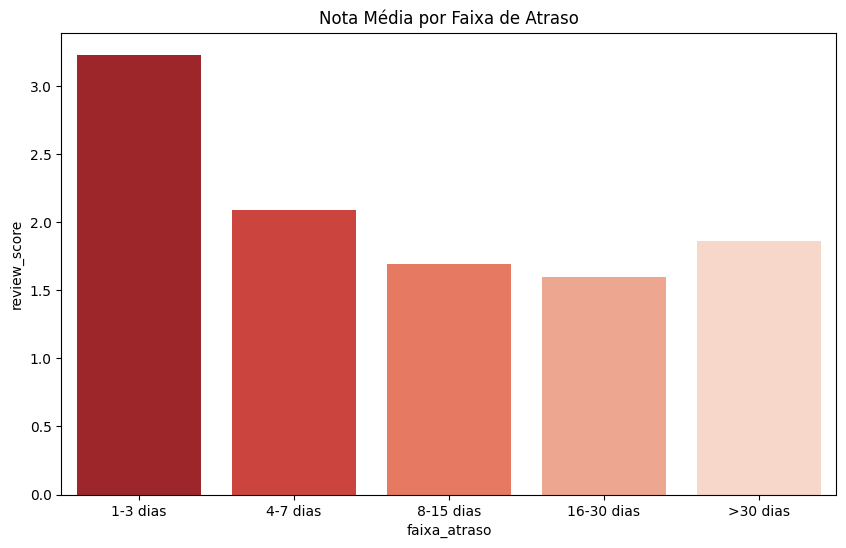

In [49]:
#criando as faixas de atraso
bins = [0, 3, 7, 15, 30, 90]
labels = ['1-3 dias', '4-7 dias', '8-15 dias', '16-30 dias', '>30 dias']

df_clean['faixa_atraso'] = pd.cut(df_clean[df_clean['dias_atraso'] > 0]['dias_atraso'], 
                                 bins=bins, labels=labels)

#calculando a média por faixa
resumo_faixas = df_clean.groupby('faixa_atraso', observed=True)['review_score'].mean().reset_index()

#grafico de barras - nota média por faixa de atraso
plt.figure(figsize=(10, 6))
sns.barplot(
    data=resumo_faixas, 
    x='faixa_atraso', 
    y='review_score', 
    hue='faixa_atraso',
    palette='Reds_r', 
    legend=False        
)
plt.title('Nota Média por Faixa de Atraso')
plt.show()

In [ ]:
#verificando a quantidade de pedidos em cada faixa
contagem_faixas = df_clean['faixa_atraso'].value_counts().sort_index()
print(contagem_faixas)

faixa_atraso
1-3 dias      2093
4-7 dias      1951
8-15 dias     1768
16-30 dias     950
>30 dias       302
Name: count, dtype: int64
